In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils |import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

In [2]:
def load_fashion_mnist_from_csv(train_csv_path, test_csv_path):
    # Load training data
    train_df = pd.read_csv(train_csv_path)
    train_labels = train_df['label'].values
    train_pixels = train_df.drop('label', axis=1).values.reshape(-1, 28, 28)

    # Load test data
    test_df = pd.read_csv(test_csv_path)
    test_labels = test_df['label'].values
    test_pixels = test_df.drop('label', axis=1).values.reshape(-1, 28, 28)

    return (train_pixels, train_labels), (test_pixels, test_labels)


In [3]:
(train_images, train_labels), (test_images, test_labels) = load_fashion_mnist_from_csv('fashion-mnist_train.csv', 'fashion-mnist_test.csv')

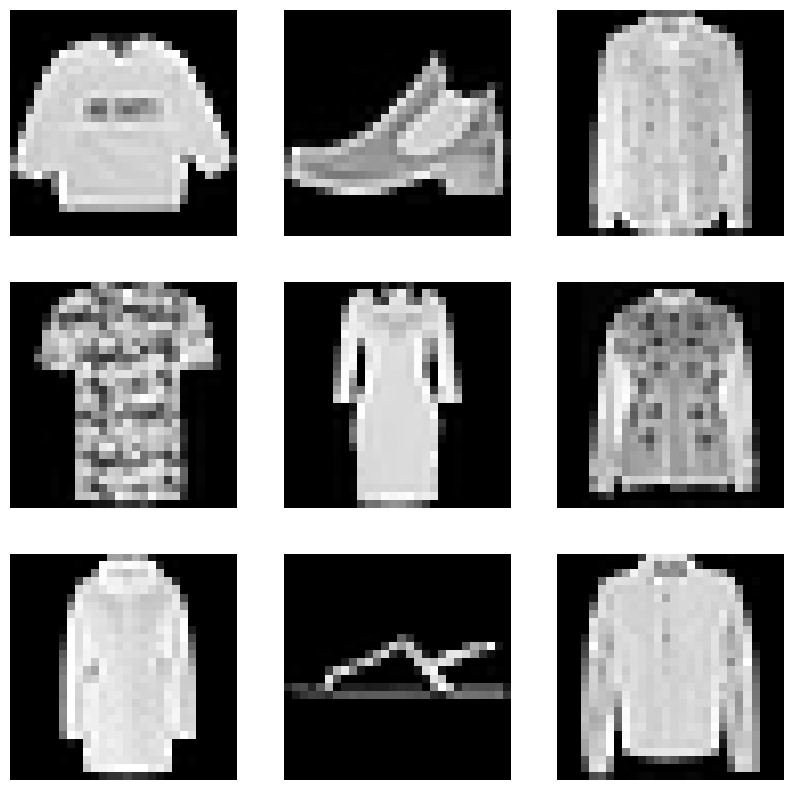

In [4]:
train_X = train_images#.drop("label", axis=1).values
train_y = train_labels#['label'].values

test_X = test_images

img_rows, img_cols = 28, 28

train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols)
test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols)

# Create subplots
fig, plts = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        plts[i, j].imshow(train_X[idx], cmap=plt.get_cmap('gray'))
        plts[i, j].axis('off')  # Turn off axis
plt.show()

In [5]:
zeros = train_X[train_y==0]
zeros.shape

ones = train_X[train_y==1]

twos = train_X[train_y==2]

threes = train_X[train_y==3]

fours = train_X[train_y==4]

fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

In [6]:
def vox_to_pointcloud(voxarray,grid,eps=0):
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]

In [7]:
def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))
    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

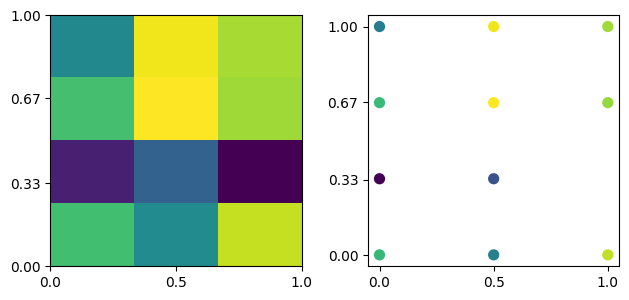

In [8]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

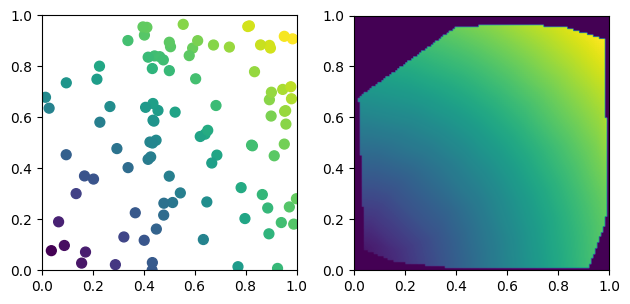

In [9]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [10]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

grid shape (2, 28, 28)


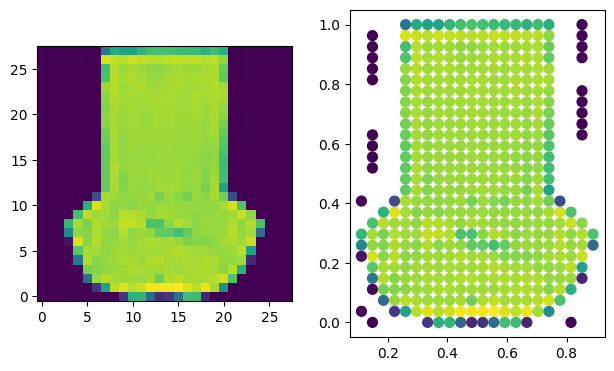

In [11]:
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx, yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

print("grid shape",grid.shape)

voxarray = zeros[1,:,:]  
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)

grid shape (2, 28, 28)


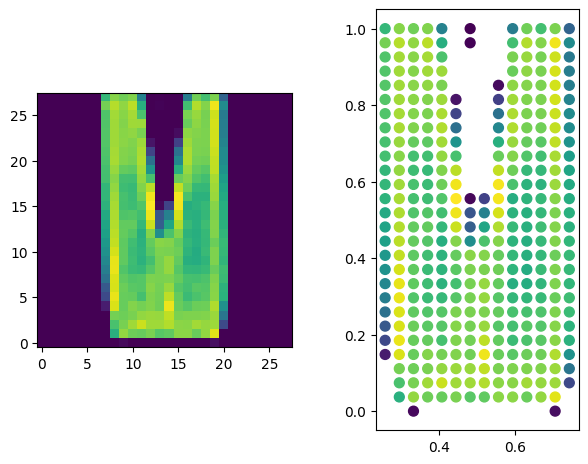

In [12]:
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx, yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

print("grid shape",grid.shape)

voxarray = ones[1,:,:]  
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)

In [13]:
num_samples = 1500
idx = np.random.choice(train_images.shape[0], num_samples, replace=False)
subset_train = train_images[idx]
subset_train_labels = train_labels[idx]

In [14]:
grid_x, grid_y = np.meshgrid(np.arange(28), np.arange(28))
grid = np.stack((grid_x, grid_y))

reshaped_images = subset_train.reshape(-1, 28, 28)
pointclouds = []
for image in reshaped_images:
    pointcloud = vox_to_pointcloud(image, grid)
    pointclouds.append(pointcloud)

In [15]:
pointclouds[1].shape

(534, 3)

In [16]:
# Generate translation images and image tensor
#trans_images = []
#for i in range(num_translates**2):
    #img = pointcloud = vox_to_pointcloud(image, grid)
    #trans_images.append(img)

In [17]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=100):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

### Embeddings

In [18]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images
    image_tensor is Mx2xN
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_array(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

In [19]:
def rotation(object, radian_degree):
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

# def diffeo(object, diff_fun):
#     object_array = np.array(object)
#     image = [diff_fun(x) for x in object_array]
#     return np.array(image)

def diffeo(object, a,b):
    object_array = np.array(object)
    image = np.array([1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(a*object_array[:,0]), 1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(b*object_array[:,1])]).T
#    image = np.array([np.exp(a*object_array[:,0]), np.reciprocal((1+b*object_array[:,1])**2)]).T
    print(image.shape)
    return np.array(image)

In [22]:
# Generate circle
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]
    
trans_images = []
for image in reshaped_images:
    pointcloud = vox_to_pointcloud(image, grid)
    trans_images.append(pointcloud)

/tmp/ipykernel_762301/1011738806.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  translates[i,0] = xx[i]
/tmp/ipykernel_762301/1011738806.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  translates[i,1] = yy[i]


Computed Wasserstein distance matrix (N = 16) in 12367.4555 seconds


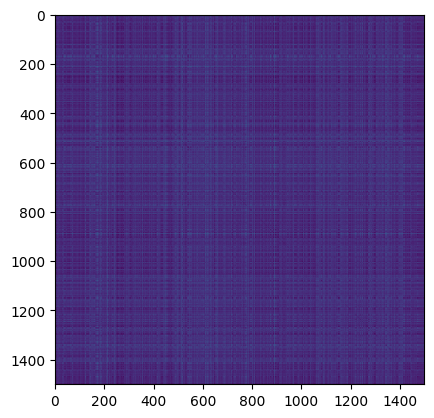

In [23]:
## Circle translation test :: Compute Wasserstein square distance matrix usinng this
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance_trans)

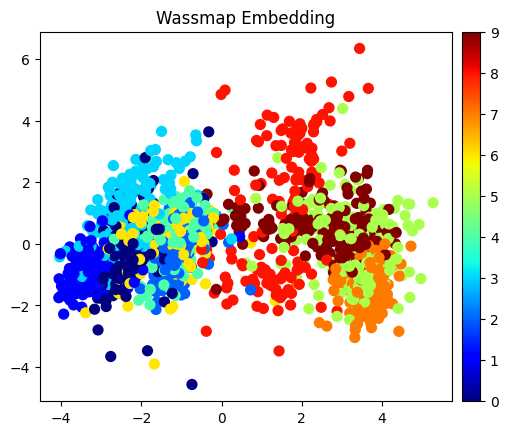

In [24]:
WassEmbedding_trans = MDS(Wass_distance_trans, squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:, 0]
scatter_y = WassEmbedding_trans[:, 1]
sc = ax1.scatter(scatter_x, scatter_y, c=subset_train_labels, cmap='jet', s=50)
ax1.set_title('Wassmap Embedding')
plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
plt.show()

In [25]:
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [26]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
Wass_embedding_mds = mds.fit_transform(Wass_distance_trans)

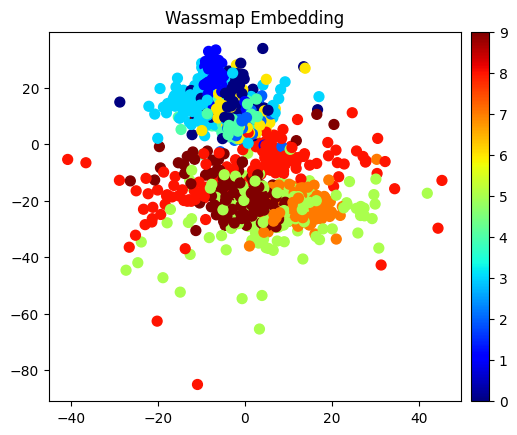

In [27]:
# Plotting the embedding
fig, ax1 = plt.subplots()
scatter_x = Wass_embedding_mds[:, 0]
scatter_y = Wass_embedding_mds[:, 1]
sc = ax1.scatter(scatter_x, scatter_y, c=subset_train_labels, cmap='jet', s=50)
ax1.set_title('Wassmap Embedding')
plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
plt.show()

In [28]:
isomap = Isomap(n_components=2, metric='precomputed')
Wass_distance_graph = kneighbors_graph(Wass_distance_trans, n_neighbors=6, include_self=True, mode='distance')
WassEmbedding_isomap = isomap.fit_transform(Wass_distance_graph)

In [29]:
tsne = TSNE(n_components=2, metric ='precomputed',init = 'random',random_state=42, perplexity=50)
WassEmbedding_tsne = tsne.fit_transform(Wass_distance_trans)

In [30]:
lle = LocallyLinearEmbedding(n_components=2, random_state=42, n_neighbors=10)
WassEmbedding_lle = lle.fit_transform(Wass_distance_trans)

In [31]:
similarity_matrix = np.exp(-Wass_distance_trans ** 2 / (4. * np.std(Wass_distance_trans) ** 2))
spectral = SpectralEmbedding(n_components=2, affinity='precomputed', random_state=42)
WassEmbedding_spectral = spectral.fit_transform(similarity_matrix)

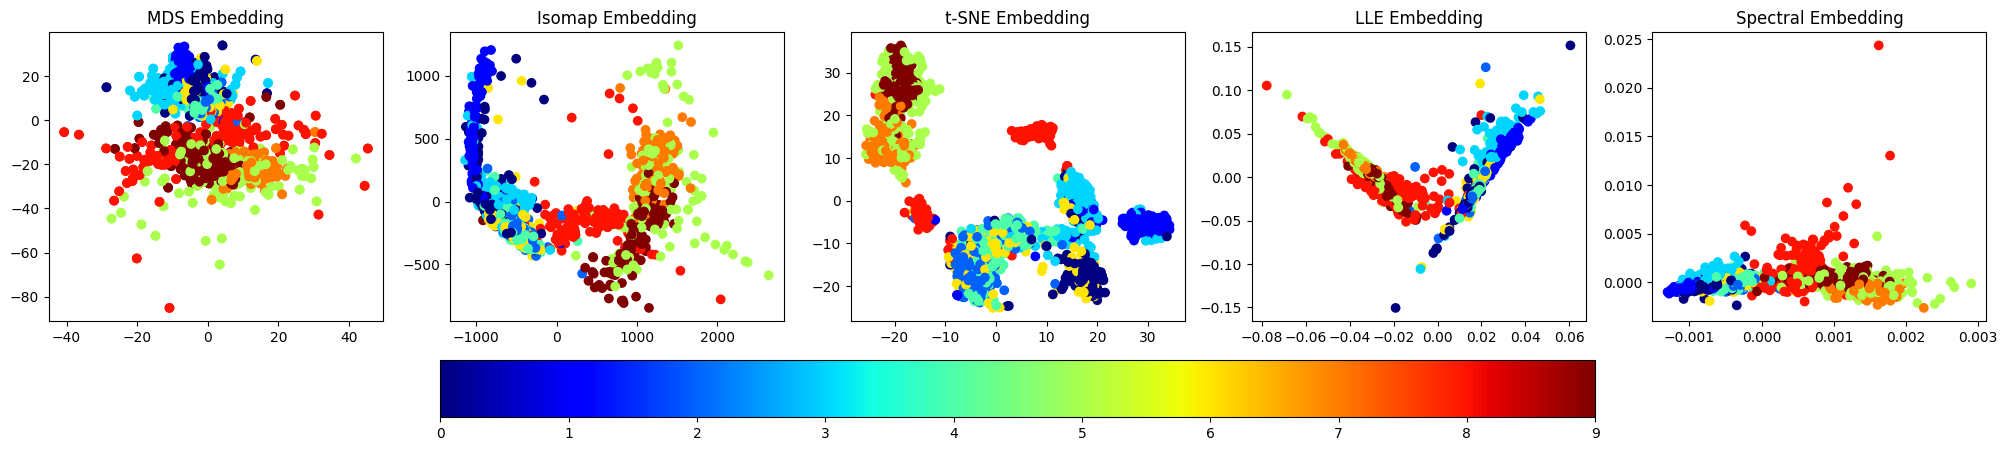

In [32]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

# MDS
axs[0].scatter(Wass_embedding_mds[:, 0], Wass_embedding_mds[:, 1], c=subset_train_labels, cmap='jet')
axs[0].set_title('MDS Embedding')

# Isomap
axs[1].scatter(WassEmbedding_isomap[:, 0], WassEmbedding_isomap[:, 1], c=subset_train_labels, cmap='jet')
axs[1].set_title('Isomap Embedding')

# t-SNE
axs[2].scatter(WassEmbedding_tsne[:, 0], WassEmbedding_tsne[:, 1], c=subset_train_labels, cmap='jet')
axs[2].set_title('t-SNE Embedding')

# LLE
axs[3].scatter(WassEmbedding_lle[:, 0], WassEmbedding_lle[:, 1], c=subset_train_labels, cmap='jet')
axs[3].set_title('LLE Embedding')

# Spectral
axs[4].scatter(WassEmbedding_spectral[:, 0], WassEmbedding_spectral[:, 1], c=subset_train_labels, cmap='jet')
axs[4].set_title('Spectral Embedding')

plt.colorbar(axs[0].scatter(Wass_embedding_mds[:, 0], Wass_embedding_mds[:, 1], c=subset_train_labels, cmap='jet'), ax=axs, orientation='horizontal', pad=0.1)
plt.show()


### Classification task

In [33]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

In [34]:
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'KNN (K=1)': KNeighborsClassifier(n_neighbors=1),
    'KNN (K=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (K=5)': KNeighborsClassifier(n_neighbors=5),
    'SVM Linear': SVC(kernel='linear'),
    'SVM RBF': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(),
    'Multinomial Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000) 
}

In [72]:
#idx = np.random.choice(train_images.shape[0], num_samples, replace=False)
subset_train = train_images[idx]
subset_train_labels = train_labels[idx]

In [69]:
#scaler = StandardScaler()
#train_scaled = scaler.fit_transform(subset_train)
X_train, X_test, y_train, y_test = train_test_split(subset_train, subset_train_labels, test_size=0.3, random_state=42)

In [70]:
print(X_train.shape)
print(X_test.shape)

(1050, 28, 28)
(450, 28, 28)


In [76]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

In [77]:
no_embedding_accuracies = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    no_embedding_accuracies[name] = accuracy
    #print(f"{name} - No Embedding: Accuracy = {accuracy:.2f}")

In [78]:
no_embedding_mean_std = {
    name: f"{np.mean(accs):.2f} ± {np.std(accs):.2f}"
    for name, accs in no_embedding_accuracies.items()}

no_embedding_df = pd.DataFrame([no_embedding_mean_std], index=['No Embedding'])
no_embedding_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,0.59 ± 0.00,0.76 ± 0.00,0.75 ± 0.00,0.79 ± 0.00,0.78 ± 0.00,0.79 ± 0.00,0.82 ± 0.00,0.74 ± 0.00


## For 10 components:

In [38]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=10, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(Wass_distance_trans)
        embeddings[(metric_value, eps)] = train_transformed

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


In [39]:
mds_accuracy_results = {name: [] for name in classifiers.keys()}

for (metric_value, eps), train_transformed in embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, subset_train_labels, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mds_accuracy_results[name].append(accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [40]:
mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

In [41]:
mds_df = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
MDS,0.66 ± 0.01,0.63 ± 0.01,0.65 ± 0.00,0.67 ± 0.01,0.67 ± 0.01,0.69 ± 0.00,0.69 ± 0.02,0.67 ± 0.01


In [85]:
n_neighbors_values = [20, 30, 40, 50]
n_components_values = [10]

transformed_isomap_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        isomap = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric = 'precomputed')
        transformed_isomap_data = isomap.fit_transform(Wass_distance_trans)
        transformed_isomap_data_list.append((n_neighbors_val, n_components_val, transformed_isomap_data))

In [86]:
isomap_accuracy_results = {name: [] for name in classifiers.keys()}
for n_neighbors_val, n_components_val, transformed_data in transformed_isomap_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Isomap (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

   
    for name in isomap_accuracy_results:
        isomap_accuracy_results[name].append(current_accuracies[name])

In [87]:
isomap_mean_std_accuracy_results = {}
for name, acc_list in isomap_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    isomap_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

isomap_df = pd.DataFrame([isomap_mean_std_accuracy_results], index=['Isomap'])
isomap_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Isomap,0.66 ± 0.00,0.70 ± 0.00,0.69 ± 0.01,0.71 ± 0.01,0.70 ± 0.01,0.73 ± 0.01,0.71 ± 0.01,0.69 ± 0.02


In [58]:
n_perplexity_values = [ 3, 5, 7]
n_components_values = [2, 3]

transformed_tsne_data_list = []
for perplexity_val in n_perplexity_values:
    for i, n_components_val in enumerate(n_components_values):
        tsne = TSNE(n_components=n_components_val, perplexity=perplexity_val, random_state=42)
        transformed_tsne_data = tsne.fit_transform(Wass_distance_trans)
        transformed_tsne_data_list.append((perplexity_val, n_components_val, transformed_tsne_data))
        

In [59]:
tsne_accuracy_results = {name: [] for name in classifiers.keys()}

for perplexity_val, n_components_val, transformed_data in transformed_tsne_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy

        #print(f"{name} with t-SNE (perplexity={perplexity_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in tsne_accuracy_results:
        tsne_accuracy_results[name].append(current_accuracies[name])

In [60]:
tsne_mean_std_accuracy_results = {}
for name, acc_list in tsne_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    tsne_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

tsne_df = pd.DataFrame([tsne_mean_std_accuracy_results], index=['t-SNE'])
tsne_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
t-SNE,0.53 ± 0.05,0.63 ± 0.01,0.63 ± 0.01,0.64 ± 0.01,0.59 ± 0.04,0.68 ± 0.02,0.65 ± 0.01,0.55 ± 0.04


In [61]:
n_neighbors_values = [ 2, 3, 5, 7]
n_components_values = [10]

transformed_lle_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_lle_data = lle.fit_transform(Wass_distance_trans)
        transformed_lle_data_list.append((n_neighbors_val, n_components_val, transformed_lle_data))     

In [62]:
lle_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_lle_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with LLE (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in lle_accuracy_results:
        lle_accuracy_results[name].append(current_accuracies[name])

In [63]:
lle_mean_std_accuracy_results = {}
for name, acc_list in lle_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    lle_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

lle_df = pd.DataFrame([lle_mean_std_accuracy_results], index=['LLE'])
lle_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
LLE,0.43 ± 0.10,0.58 ± 0.01,0.57 ± 0.01,0.59 ± 0.01,0.10 ± 0.01,0.58 ± 0.02,0.61 ± 0.02,0.35 ± 0.15


In [64]:
n_neighbors_values = [ 3, 5, 7,10]
n_components_values = [10]

transformed_spectral_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        spectral = SpectralEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_spectral_data = spectral.fit_transform(Wass_distance_trans)
        transformed_spectral_data_list.append((n_neighbors_val, n_components_val, transformed_spectral_data))

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [65]:
spectral_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_spectral_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Spectral Embedding (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in spectral_accuracy_results:
        spectral_accuracy_results[name].append(current_accuracies[name])

In [66]:
spectral_mean_std_accuracy_results = {}
for name, acc_list in spectral_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    spectral_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

spectral_df = pd.DataFrame([spectral_mean_std_accuracy_results], index=['Spectral Embedding'])
spectral_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Spectral Embedding,0.58 ± 0.08,0.56 ± 0.02,0.58 ± 0.03,0.61 ± 0.04,0.09 ± 0.00,0.63 ± 0.07,0.59 ± 0.04,0.33 ± 0.10


In [88]:
combined_df = pd.concat([no_embedding_df, mds_df, isomap_df, tsne_df, lle_df, spectral_df])
combined_df

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,0.59 ± 0.00,0.76 ± 0.00,0.75 ± 0.00,0.79 ± 0.00,0.78 ± 0.00,0.79 ± 0.00,0.82 ± 0.00,0.74 ± 0.00
MDS,0.66 ± 0.01,0.63 ± 0.01,0.65 ± 0.00,0.67 ± 0.01,0.67 ± 0.01,0.69 ± 0.00,0.69 ± 0.02,0.67 ± 0.01
Isomap,0.66 ± 0.00,0.70 ± 0.00,0.69 ± 0.01,0.71 ± 0.01,0.70 ± 0.01,0.73 ± 0.01,0.71 ± 0.01,0.69 ± 0.02
t-SNE,0.53 ± 0.05,0.63 ± 0.01,0.63 ± 0.01,0.64 ± 0.01,0.59 ± 0.04,0.68 ± 0.02,0.65 ± 0.01,0.55 ± 0.04
LLE,0.43 ± 0.10,0.58 ± 0.01,0.57 ± 0.01,0.59 ± 0.01,0.10 ± 0.01,0.58 ± 0.02,0.61 ± 0.02,0.35 ± 0.15
Spectral Embedding,0.58 ± 0.08,0.56 ± 0.02,0.58 ± 0.03,0.61 ± 0.04,0.09 ± 0.00,0.63 ± 0.07,0.59 ± 0.04,0.33 ± 0.10


In [89]:
from scipy.stats import ttest_ind
techniques_10 = combined_df.index.tolist()

In [90]:
def perform_one_sided_ttest(no_embedding_means, technique_means):
    t_stat, p_value = ttest_ind( technique_means,no_embedding_means, equal_var=False, alternative = 'less')
    #if t_stat > 0:
        #p_value /= 2
    #else:
        #p_value = 1 - (p_value / 2)
    return p_value

ttest_results_10 = {}
for technique in techniques_10:
    if technique == 'No Embedding':
        continue
    
    # Extract the mean accuracies as floats
    no_embedding_means = combined_df.loc['No Embedding'].str.split(' ± ').str[0].astype(float)
    technique_means = combined_df.loc[technique].str.split(' ± ').str[0].astype(float)
    
    # Perform the one-sided t-test
    p_value = perform_one_sided_ttest(no_embedding_means, technique_means)
    ttest_results_10[technique] = p_value

In [91]:
# H_0: Embedded performance is less than or equal to no_embedding performance 
# H_a: Embedded performance is better than no_embedding performance 

In [92]:
print("One-Sided T-Test Results for 10 Components:")
for technique, p_value in ttest_results_10.items():
    print(f"{technique}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference at p < 0.05, reject H0")
    else:
        print("  No significant difference, fail to reject H0")

One-Sided T-Test Results for 10 Components:
MDS: p-value = 0.0051
  Significant difference at p < 0.05, reject H0
Isomap: p-value = 0.0356
  Significant difference at p < 0.05, reject H0
t-SNE: p-value = 0.0003
  Significant difference at p < 0.05, reject H0
LLE: p-value = 0.0013
  Significant difference at p < 0.05, reject H0
Spectral Embedding: p-value = 0.0030
  Significant difference at p < 0.05, reject H0


# For 100 components:

In [84]:
metrics = [True]
eps_values = [0.001, 0.01, 0.1]
embeddings = {}
for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=100, metric=metric_value, eps=eps)
        train_transformed = embedding.fit_transform(Wass_distance_trans)
        embeddings[(metric_value, eps)] = train_transformed

mds_accuracy_results = {name: [] for name in classifiers.keys()}

for (metric_value, eps), train_transformed in embeddings.items():
    X_train, X_test, y_train, y_test = train_test_split(train_transformed, subset_train_labels, test_size=0.3, random_state=42)
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mds_accuracy_results[name].append(accuracy)

mds_mean_std_accuracy_results = {}
for name, acc_list in mds_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    mds_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

mds_df_100 = pd.DataFrame([mds_mean_std_accuracy_results], index=['MDS'])
mds_df_100

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter)

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
MDS,0.68 ± 0.02,0.63 ± 0.00,0.64 ± 0.00,0.67 ± 0.00,0.63 ± 0.01,0.68 ± 0.00,0.72 ± 0.00,0.60 ± 0.02


In [93]:
n_neighbors_values = [20, 30, 40, 50]
n_components_values = [100]

transformed_isomap_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        isomap = Isomap(n_neighbors=n_neighbors_val, n_components=n_components_val, metric = 'precomputed')
        transformed_isomap_data = isomap.fit_transform(Wass_distance_trans)
        transformed_isomap_data_list.append((n_neighbors_val, n_components_val, transformed_isomap_data))

isomap_accuracy_results = {name: [] for name in classifiers.keys()}
for n_neighbors_val, n_components_val, transformed_data in transformed_isomap_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Isomap (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

   
    for name in isomap_accuracy_results:
        isomap_accuracy_results[name].append(current_accuracies[name])

isomap_mean_std_accuracy_results = {}
for name, acc_list in isomap_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    isomap_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

isomap_df_100 = pd.DataFrame([isomap_mean_std_accuracy_results], index=['Isomap'])
isomap_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Isomap,0.72 ± 0.00,0.72 ± 0.01,0.72 ± 0.00,0.72 ± 0.01,0.76 ± 0.01,0.75 ± 0.01,0.76 ± 0.01,0.76 ± 0.01


In [95]:
n_neighbors_values = [ 2, 3, 5, 7]
n_components_values = [100]

transformed_lle_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_lle_data = lle.fit_transform(Wass_distance_trans)
        transformed_lle_data_list.append((n_neighbors_val, n_components_val, transformed_lle_data))     

lle_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_lle_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with LLE (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in lle_accuracy_results:
        lle_accuracy_results[name].append(current_accuracies[name])

lle_mean_std_accuracy_results = {}
for name, acc_list in lle_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    lle_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

lle_df_100 = pd.DataFrame([lle_mean_std_accuracy_results], index=['LLE'])
lle_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
LLE,0.67 ± 0.02,0.61 ± 0.03,0.61 ± 0.03,0.63 ± 0.02,0.38 ± 0.04,0.68 ± 0.01,0.65 ± 0.02,0.63 ± 0.01


In [97]:
n_neighbors_values = [ 3, 5, 7,10]
n_components_values = [100]

transformed_spectral_data_list = []
for n_neighbors_val in n_neighbors_values:
    for i, n_components_val in enumerate(n_components_values):
        spectral = SpectralEmbedding(n_neighbors=n_neighbors_val, n_components=n_components_val)
        transformed_spectral_data = spectral.fit_transform(Wass_distance_trans)
        transformed_spectral_data_list.append((n_neighbors_val, n_components_val, transformed_spectral_data))

spectral_accuracy_results = {name: [] for name in classifiers.keys()}

for n_neighbors_val, n_components_val, transformed_data in transformed_spectral_data_list:
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, subset_train_labels, test_size=0.3, random_state=42)
    current_accuracies = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        current_accuracies[name] = accuracy
        #print(f"{name} with Spectral Embedding (n_neighbors={n_neighbors_val}, n_components={n_components_val}) - Accuracy: {accuracy:.2f}")

    for name in spectral_accuracy_results:
        spectral_accuracy_results[name].append(current_accuracies[name])

spectral_mean_std_accuracy_results = {}
for name, acc_list in spectral_accuracy_results.items():
    mean_accuracy = np.mean(acc_list)
    std_accuracy = np.std(acc_list)
    spectral_mean_std_accuracy_results[name] = f"{mean_accuracy:.2f} ± {std_accuracy:.2f}"

spectral_df_100 = pd.DataFrame([spectral_mean_std_accuracy_results], index=['Spectral Embedding'])
spectral_df_100

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
Spectral Embedding,0.69 ± 0.02,0.59 ± 0.02,0.61 ± 0.02,0.64 ± 0.02,0.09 ± 0.00,0.68 ± 0.02,0.64 ± 0.01,0.44 ± 0.14


In [99]:
combined_df_100 = pd.concat([no_embedding_df, mds_df_100, isomap_df_100, tsne_df, lle_df_100, spectral_df_100])
combined_df_100

,LDA,KNN (K=1),KNN (K=3),KNN (K=5),SVM Linear,SVM RBF,Random Forest,Multinomial Logistic Regression
No Embedding,0.59 ± 0.00,0.76 ± 0.00,0.75 ± 0.00,0.79 ± 0.00,0.78 ± 0.00,0.79 ± 0.00,0.82 ± 0.00,0.74 ± 0.00
MDS,0.68 ± 0.02,0.63 ± 0.00,0.64 ± 0.00,0.67 ± 0.00,0.63 ± 0.01,0.68 ± 0.00,0.72 ± 0.00,0.60 ± 0.02
Isomap,0.72 ± 0.00,0.72 ± 0.01,0.72 ± 0.00,0.72 ± 0.01,0.76 ± 0.01,0.75 ± 0.01,0.76 ± 0.01,0.76 ± 0.01
t-SNE,0.53 ± 0.05,0.63 ± 0.01,0.63 ± 0.01,0.64 ± 0.01,0.59 ± 0.04,0.68 ± 0.02,0.65 ± 0.01,0.55 ± 0.04
LLE,0.67 ± 0.02,0.61 ± 0.03,0.61 ± 0.03,0.63 ± 0.02,0.38 ± 0.04,0.68 ± 0.01,0.65 ± 0.02,0.63 ± 0.01
Spectral Embedding,0.69 ± 0.02,0.59 ± 0.02,0.61 ± 0.02,0.64 ± 0.02,0.09 ± 0.00,0.68 ± 0.02,0.64 ± 0.01,0.44 ± 0.14


In [100]:
techniques_100 = combined_df_100.index.tolist()
def perform_one_sided_ttest(no_embedding_means, technique_means):
    t_stat, p_value = ttest_ind( technique_means,no_embedding_means, equal_var=False, alternative = 'less')
    #if t_stat > 0:
        #p_value /= 2
    #else:
        #p_value = 1 - (p_value / 2)
    return p_value

ttest_results_100 = {}
for technique in techniques_100:
    if technique == 'No Embedding':
        continue
    
    # Extract the mean accuracies as floats
    no_embedding_means = combined_df_100.loc['No Embedding'].str.split(' ± ').str[0].astype(float)
    technique_means = combined_df_100.loc[technique].str.split(' ± ').str[0].astype(float)
    
    # Perform the one-sided t-test
    p_value = perform_one_sided_ttest(no_embedding_means, technique_means)
    ttest_results_100[technique] = p_value

print("One-Sided T-Test Results for 100 Components:")
for technique, p_value in ttest_results_100.items():
    print(f"{technique}: p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("  Significant difference at p < 0.05, reject H0")
    else:
        print("  No significant difference, fail to reject H0")

One-Sided T-Test Results for 100 Components:
MDS: p-value = 0.0031
  Significant difference at p < 0.05, reject H0
Isomap: p-value = 0.3050
  No significant difference, fail to reject H0
t-SNE: p-value = 0.0003
  Significant difference at p < 0.05, reject H0
LLE: p-value = 0.0021
  Significant difference at p < 0.05, reject H0
Spectral Embedding: p-value = 0.0120
  Significant difference at p < 0.05, reject H0
